# Purpose of the Code

The goal of this notebook is to extract EMG signals recorded using Trigno system, process the raw data, extract meaningful features, and store the resulting information in a structured DataFrame format.


## Libraries

In [1]:
#pip install libemg
#pip install --upgrade paramiko cryptography
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('../../lib')
from import_emg_file import import_data_from_trigno
from trigno_utils import trigno_dataframe_edit, trigno_extract_muscle_emg
from emg_utils import (plot_emg_signal, emg_filters, extract_emg_windows, extract_emg_features, 
                        combine_multiple_features_lists, detect_segmented_breakpoints)

# Loading Data Files

In [2]:
intensity = "light" # "light", "medium", "heavy" 
muscle_name = "biceps" # "biceps", "triceps", "forearm1", "forearm2"

In [3]:
folder_path = f'../../data/acquisitions/trigno/05_14/{intensity}/'
dataframes = import_data_from_trigno(folder_path)
dataframes = [trigno_dataframe_edit(df) for df in dataframes]

In [4]:
muscle_emg_raw, emg_time = trigno_extract_muscle_emg (dataframes, muscle_name)
#plot_emg_signal(muscle_emg_raw[0], emg_time[0], title=f"{muscle_name} EMG Raw Signal #1")

# EMG Signal Analysis

## Filtering and Smoothing

In [5]:
muscle_emg_filtered, _, _, muscle_emg_normalized = emg_filters(muscle_emg_raw, emg_time, muscle_name)
#plot_emg_signal(muscle_emg_normalized[0], emg_time[0], title=f"{muscle_name} EMG Normalized Signal #1", ylabel="%MVC")

## Windowing and Features Extraction

Windowing

In [6]:
normalized_win, filtered_win, time_win = extract_emg_windows(muscle_emg_normalized, muscle_emg_filtered, emg_time)

Features Extraction

In [7]:
features_list_norm = ['MAV', 'WL', 'RMS', 'VAR', 'IAV', 'KURT', 'SKEW', 'AR4', 'LD', 'SAMPEN', 'MPK']
features_list_filt = ['ZC', 'SSC', 'WAMP']
features_list_freq = ['MNF', 'MNP', 'SM', 'ISD']

time_features_norm = extract_emg_features(normalized_win, features_list_norm)
time_features_filt = extract_emg_features(filtered_win, features_list_filt)
freq_features_norm = extract_emg_features(normalized_win, features_list_freq)

In [8]:
dfs = combine_multiple_features_lists(time_features_norm, time_features_filt, freq_features_norm)

## Label Assignment

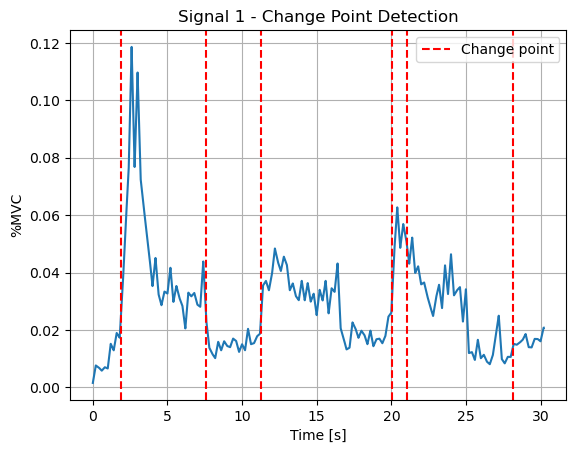

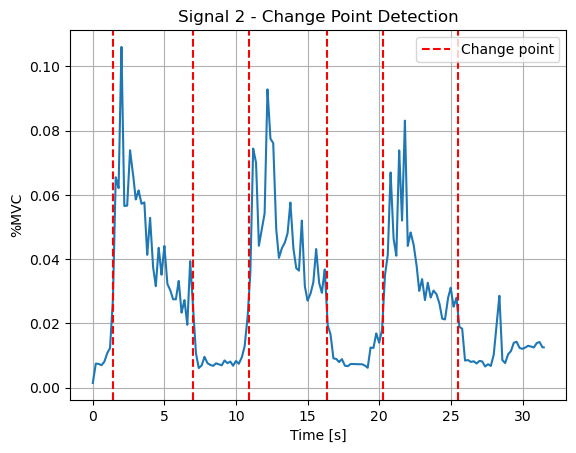

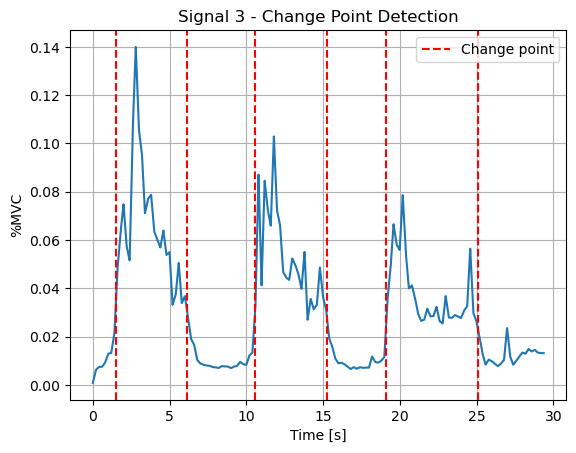

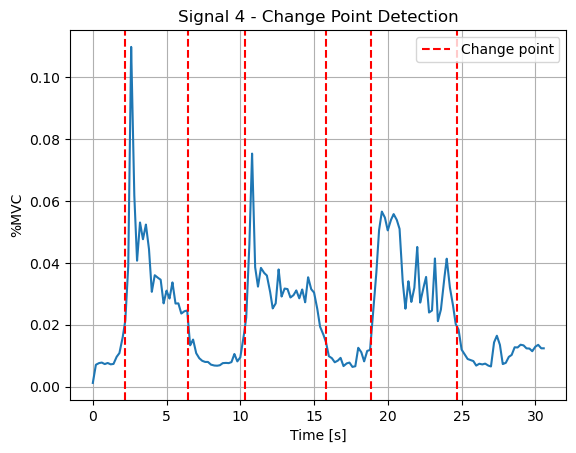

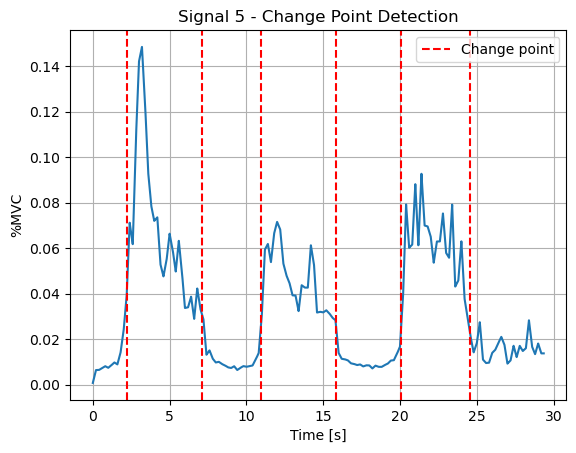

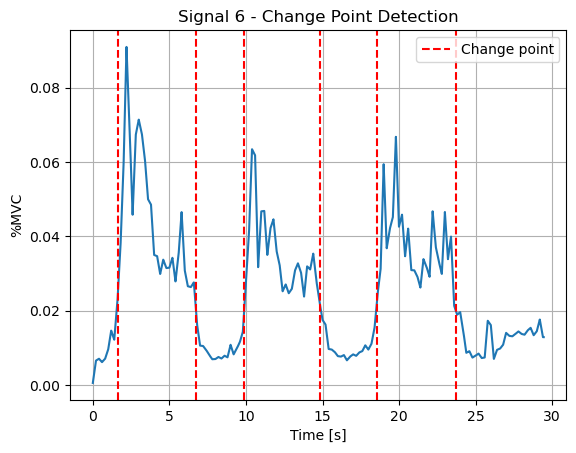

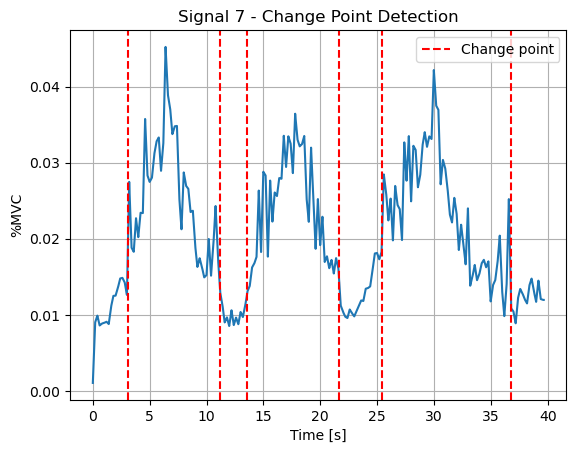

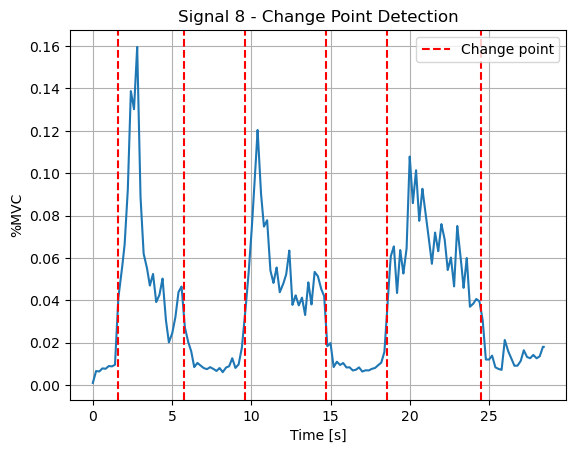

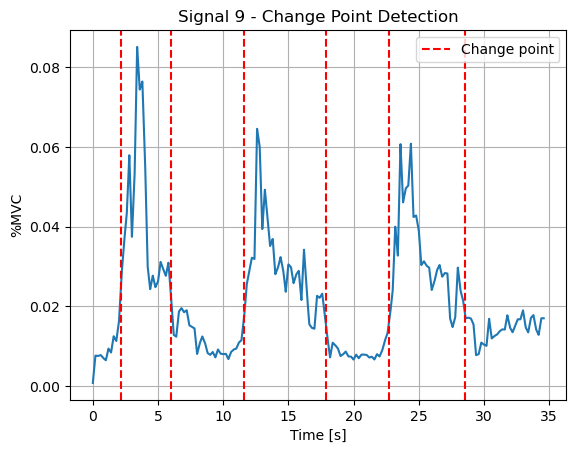

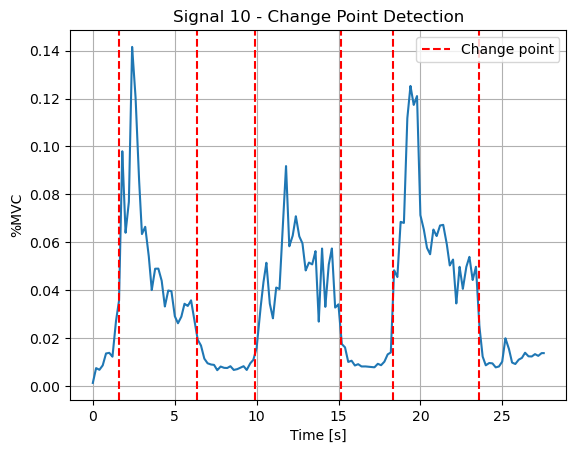

In [9]:
n_bkps = 6 #Twice the number of lifts
all_bkps_list = detect_segmented_breakpoints(muscle_emg_normalized, emg_time, intensity, n_bkps)

In [10]:
def assign_labels_by_indices(total_windows, start_indices, labels):
    assigned_labels = [''] * total_windows

    for i in range(len(start_indices)):
        start = start_indices[i]
        end = start_indices[i+1] if i+1 < len(start_indices) else total_windows

        for w in range(start, end):
            assigned_labels[w] = labels[i]

    return assigned_labels

In [11]:
#labels = ['no weight', 'light', 'no weight', 'light', 'no weight', 'light', 'no weight']
labels = ['no weight', intensity, 'no weight', intensity, 'no weight', intensity, 'no weight']                   

# Parametri finestra
window_duration = 0.2  # secondi
overlap = 0.5          # 50% overlap

dt = np.mean(np.diff(emg_time[0])) 
fs = 1 / dt     

window_size = int(window_duration * fs)
step = int(window_size * (1 - overlap))

assigned_labels_list = []  # lista dove mettere tutte le label assegnate

for i, all_bkps in enumerate(all_bkps_list):
    total_windows = len(normalized_win[i])# lunghezza del DataFrame corrispondente
    windows_start = [0] + all_bkps[:]
    windows_start_windows = [w for idx in windows_start for w in [idx // step] if w < total_windows]
    
    assigned_labels = assign_labels_by_indices(total_windows, windows_start_windows, labels)
    assigned_labels_list.append(assigned_labels)

all_assigned_labels = [label for sublist in assigned_labels_list for label in sublist]

In [12]:
dfs['label'] = all_assigned_labels

# Features Export

In [13]:
output_folder = '../../data/extracted_features/trigno/S01_05_14/'
output_filename = f"features_{intensity}_{muscle_name}.csv"
output_path = os.path.join(output_folder, output_filename)

dfs.to_csv(output_path, index=False)